In [1]:
from coffee_bean_detector import CoffeeDetector
import cv2
import spectral
from yolov8 import YoloDetector
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
img_path = glob.glob(rf'G:\20250807\moldy\1_20250807_092841\hk\*.png')
msi_path = glob.glob(rf'G:\20250807\moldy\1_20250807_092841\vSpex\*.hdr')
rgb_img = cv2.imread(img_path[-1])

### 白板校正

d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
d:\code\咖啡豆线扫系统协作代码\md-line-scan-detection-dev\model\white_board_correction.py:47: RuntimeWarning: invalid value encountered in divide
  reflect[j, :, i] = (msi[j, :, i].reshape(-1) / self.baiban_hengzhou[:, i]) * reflectivity


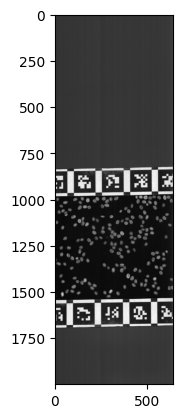

In [3]:
from white_board_correction import WhiteBoardCorrection
baiban_path = rf'G:\20250807\whiteboard\1-6_1_20250807_094655\vSpex\vSpex_20250807T094657_920.hdr'

msi = spectral.open_image(msi_path[0]).load()
# 创建白板校正对象
correction = WhiteBoardCorrection(baiban_path)
# 使用白板校正对象对样品光谱数据进行反射率校正
reflect = correction.get_reflect_line_sweep(msi)

# 绘制校正后的第8个波段的反射率图像
plt.imshow(reflect[:, :, 8], cmap='gray')

### 裁剪后配准

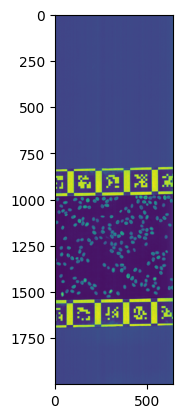

In [4]:
plt.imshow(reflect[:,:,8])

In [5]:
from coffeeImageRegistrator import ImageRegistrator
import glob

reg1 = ImageRegistrator(
    ref_path = img_path[-1],
    mov_path = msi_path[0]
)
ref_reg = reg1.warp_image(reflect)

In [ ]:
###保存数据查看配准情况
cv2.imwrite(rf'G:\20250807\moldy\1_20250807_092841\hk\test.png', ref_reg[:,:,8]*255)

True

### 融合与裁剪

In [6]:
combined_image = np.concatenate((  ref_reg , rgb_img ), axis=2)


In [7]:
import importlib
import segmentation
importlib.reload(segmentation)

<module 'segmentation' from 'd:\\code\\咖啡豆线扫系统协作代码\\md-line-scan-detection-dev\\model\\segmentation.py'>

In [9]:

from segmentation import segmentation_all

image_segmentation = segmentation_all(combined_image)

# image_bgr = image[:,: ,-3:].copy()

### 使用目标检测提取ROI

In [16]:
from typing import List, Tuple
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_roi(hyper_gray: np.ndarray, msi_res: List[Tuple[int, int, int, int]]) -> None:
    """
    在 hyper_cv 图像上显示 msi_res 中定义的 ROI 区域。

    :param hyper_gray: 单通道的灰度图像。
    :param msi_res: 包含边界框坐标的列表，每个边界框是一个 (cx, cy, w, h) 格式的元组。
    """
    hyper_cv = cv2.cvtColor(hyper_gray, cv2.COLOR_GRAY2BGR)
    for box in msi_res:
        cx, cy, w, h = box
        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)
        cv2.rectangle(hyper_cv, (x1, y1), (x2, y2), (255, 0, 0), 3)
    plt.imshow(hyper_cv)
    plt.axis('off')  # 隐藏坐标轴

def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    将图像的像素值归一化到 0-255 范围内。

    :param image: 输入图像。
    :return: 归一化后的图像。
    """
    min_val, max_val = image.min(), image.max()
    normalized_image = (image - min_val) / (max_val - min_val) * 255
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image

def extract_roi(image: np.ndarray, boxes: List[Tuple[int, int, int, int]]) -> List[np.ndarray]:
    """
    从图像中提取基于边界框坐标的区域兴趣 (ROI)。

    :param image: 原始图像。
    :param boxes: 包含边界框坐标的列表，每个边界框是一个 (cx, cy, w, h) 格式的元组。
    :return: 提取的 ROI 图像列表。
    """
    rois = []
    for box in boxes:
        cx, cy, w, h = box
        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)
        roi = image[y1:y1+h, x1:x1+w]
        rois.append(roi)
    return rois

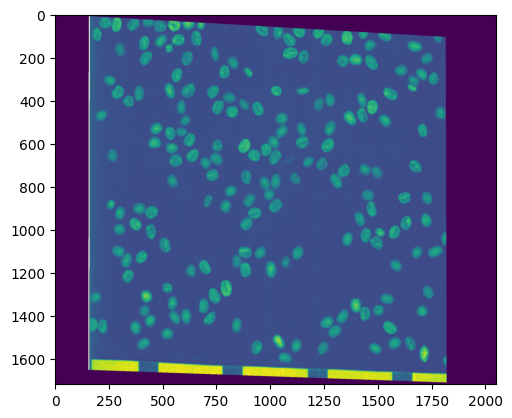

In [14]:
plt.imshow(hyper[:,:,8])

C:\Users\dell\AppData\Local\Temp\ipykernel_10136\1704106718.py:8: RuntimeWarning: invalid value encountered in cast
  hyper_gray = hyper_gray.astype(np.uint8)


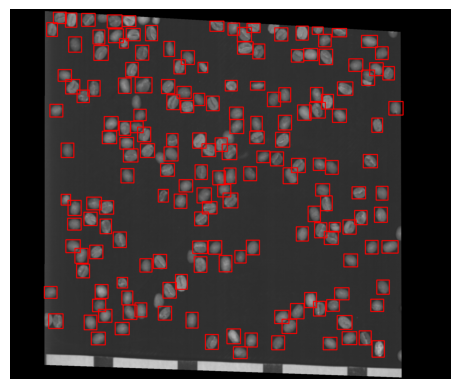

In [19]:
yolo_file = rf'D:\code\咖啡豆线扫系统协作代码\md-line-scan-detection-dev\model\models\coffeebean_v5.onnx'
yolo = YoloDetector(yolo_file)


hyper = image_segmentation

hyper_gray = hyper[:,:,8]*255
hyper_gray = hyper_gray.astype(np.uint8)
hyper_cv = cv2.cvtColor(hyper_gray, cv2.COLOR_GRAY2BGR)
msi_res = yolo.detect_obj(hyper_cv)


show_roi(hyper_gray ,msi_res )

rois = extract_roi(hyper, msi_res)



### 保存切割完的图片为tiff图片

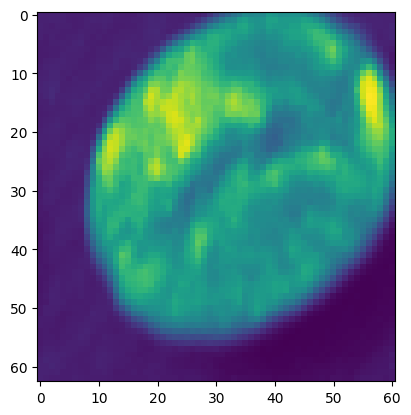

In [31]:
rois[0][0:-3] = rois[0][0:-3]*255
rois[0] = rois[0].astype(np.uint8)
plt.imshow(rois[0][:,:,-1])

In [21]:
roi_uint16 = (reflect * 65535).astype(np.uint16)
cv2.imwritemulti(f"test\\a.tiff", roi_uint16.transpose(2, 0, 1))

C:\Users\dell\AppData\Local\Temp\ipykernel_10136\1527925777.py:1: RuntimeWarning: invalid value encountered in cast
  roi_uint16 = (reflect * 65535).astype(np.uint16)


True

In [53]:
for i in range(len(rois)):
  roi_uint16 = (rois[i] * 65535).astype(np.uint16)
  cv2.imwritemulti(f"test\\{i}.tiff", roi_uint16.transpose(2, 0, 1))

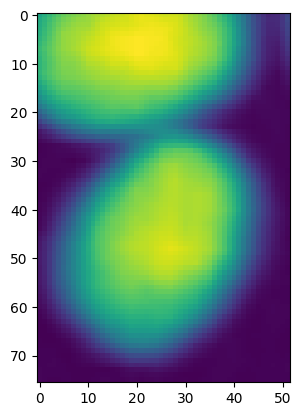

In [54]:
plt.imshow(roi_uint16[:,:,0])

### 读取tiff图片进行阈值分割，提取轮廓与光谱信息

In [72]:
from glob import glob
import spectral
import numpy as np
import matplotlib.pyplot as plt
import cv2
tiff_list = glob(rf'test\*.tiff')

In [78]:
a = cv2.imreadmulti(tiff_list[0] )
a = np.array(a[1])
a = a.transpose(1, 2, 0)
a

array([[[86, 40, 40, ..., 30, 27, 27],
        [85, 40, 40, ..., 29, 28, 29],
        [85, 39, 40, ..., 27, 27, 26],
        ...,
        [88, 40, 40, ..., 27, 25, 25],
        [88, 40, 40, ..., 29, 24, 26],
        [88, 40, 40, ..., 28, 26, 26]],

       [[86, 39, 40, ..., 30, 29, 29],
        [85, 39, 40, ..., 27, 28, 27],
        [85, 39, 40, ..., 22, 30, 28],
        ...,
        [88, 40, 40, ..., 27, 25, 27],
        [88, 40, 40, ..., 27, 27, 27],
        [88, 40, 40, ..., 28, 27, 28]],

       [[86, 39, 39, ..., 25, 31, 28],
        [86, 39, 39, ..., 23, 29, 27],
        [86, 39, 39, ..., 22, 26, 26],
        ...,
        [88, 40, 40, ..., 27, 26, 27],
        [88, 40, 40, ..., 26, 26, 27],
        [87, 40, 40, ..., 28, 26, 28]],

       ...,

       [[85, 39, 39, ..., 19, 19, 20],
        [85, 39, 39, ..., 18, 19, 19],
        [85, 39, 39, ..., 20, 19, 18],
        ...,
        [88, 41, 40, ...,  5, 38, 24],
        [88, 40, 40, ...,  8, 30, 21],
        [88, 40, 40, ..., 10, 23

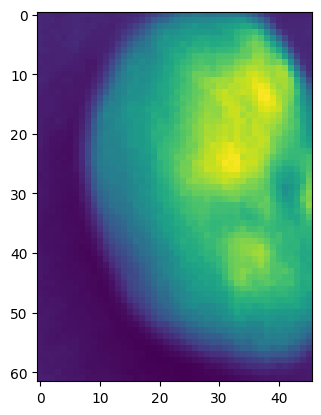

In [97]:
a = cv2.imreadmulti(tiff_list[0] )
a = np.array(a[1])
a = a.transpose(1, 2, 0)

plt.imshow(a[:,:,-1])

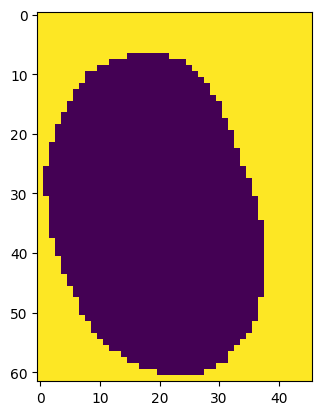

In [96]:
mask = get_mask_coffee_bean(a)
plt.imshow(mask)

In [59]:
wavelength = [
949.95,
1000.02,
1050.66,
1099.92,
1149.23,
1200.12,
1249.27,
1299.99,
1350.69,
1399.82,
1424.44,
1450.74,
1475.45,
1500.22,
1549.94,
1599.88,
700,
600,
500]

In [89]:
Spectrum = []
Feature = []
for tiff in tiff_list :

  a = cv2.imreadmulti(tiff)
  a = np.array(a[1])
  a = a.transpose(1, 2, 0)
  mask = get_mask_coffee_bean(a)
  spectrum = get_spectrum_mask( a , mask )
  feature = fetch_feature(a,  mask )

  Spectrum.append(spectrum)
  Feature.append(feature)

In [92]:
np.array(Spectrum)[:,1:-3]

array([[57.89541008, 58.80662152, 60.30549285, ..., 53.36945071,
        55.92851768, 61.90218209],
       [58.0785124 , 58.43057851, 58.68595041, ..., 50.76115702,
        52.69586777, 58.03719008],
       [60.7952381 , 61.38571429, 62.38380952, ..., 52.12857143,
        54.22      , 59.98666667],
       ...,
       [56.97198132, 57.44096064, 57.90860574, ..., 49.97264843,
        51.94663109, 57.21280854],
       [58.67459643, 59.06372133, 59.64316058, ..., 52.77909941,
        54.77655055, 60.52251487],
       [59.81485053, 60.54484089, 61.65670203, ..., 51.48023144,
        53.52459016, 59.57666345]], shape=(119, 15))

In [ ]:

from matplotlib import pyplot as plt
from skimage.measure import regionprops
import numpy as np
import cv2 as cv
import cv2
import os
import glob
from skimage.feature import graycomatrix, graycoprops

def fetch_feature(image1, mask1):
    mask1 = get_mask_coffee_bean(image1)
#     获取颜色特征
    c1 = np.mean(image1[mask1], axis=0)
#     烟叶的基本形态特征，包括面积、周长、椭圆度、面积占边界框面积的比例
    props = regionprops(mask1.astype(np.uint8))

    prop = props[0]
    region_feature = [prop.area, prop.perimeter, prop.eccentricity, prop.extent, prop.convex_area, 
                      prop.major_axis_length, prop.minor_axis_length, prop.major_axis_length/prop.minor_axis_length,
                      prop.solidity
                     ]

#     region_feature = region_features[0]
#     纹理特征，灰度共生矩阵
    glcm = graycomatrix(image1[mask1], distances=[1], angles=[0], levels=256,symmetric=True, normed=True)
    glcm_feature = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        glcm_feature.append(graycoprops(glcm, prop)[0][0])

    feature = [*c1, *region_feature, *glcm_feature]
    return feature

def get_spectrum_mask( msi , mask ):
  """
    msi: 3D array of shape (rows, columns, bands)
    mask: 2D array of shape (rows, columns)
  """
  spectrum = []
  mask = mask.astype(bool)
  shape = msi.shape
  for i in range(msi.shape[2]):
      flattened_msi = msi[:, :, i].reshape(shape[0] , shape[1])
      spectrum.append(np.mean(flattened_msi[mask]))
  # plt.plot(spectrum)
  return spectrum

def get_mask_coffee_bean(img):
    # 使用 Otsu 方法计算阈值
  _, threshold = cv2.threshold(img[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # 创建掩膜，其中亮的像素为 True，暗的像素为 False
  mask = img[:,:,0] > threshold

  # 如果需要将掩膜转换为二值图像
  binary_mask = np.where(mask, 255, 0).astype(np.uint8)

  return binary_mask.astype(bool)